# pyGIMLi(empymod)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli
import empymod

## Create model and data

In [2]:
# Offsets
x = np.linspace(1000, 20000, 20)
depth = [0, 1000, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

freqs = [0.1, 0.3, 1, 3]

mtrue = [2e14, 0.3, 1, 1, 1, 1, 1, 100, 1, 1, 1, 1]
m0 = [2e14, 0.3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Model parameters
inp = {
   'src': [0, 0, 900],
   'rec': [x, np.zeros(x.shape), 1000],
   'depth': depth,
   'freqtime': freqs,
   'verb': 1,
}

data = empymod.dipole(res=mtrue, **inp)
data0 = empymod.dipole(res=m0, **inp)
error = data.amp()*0.05

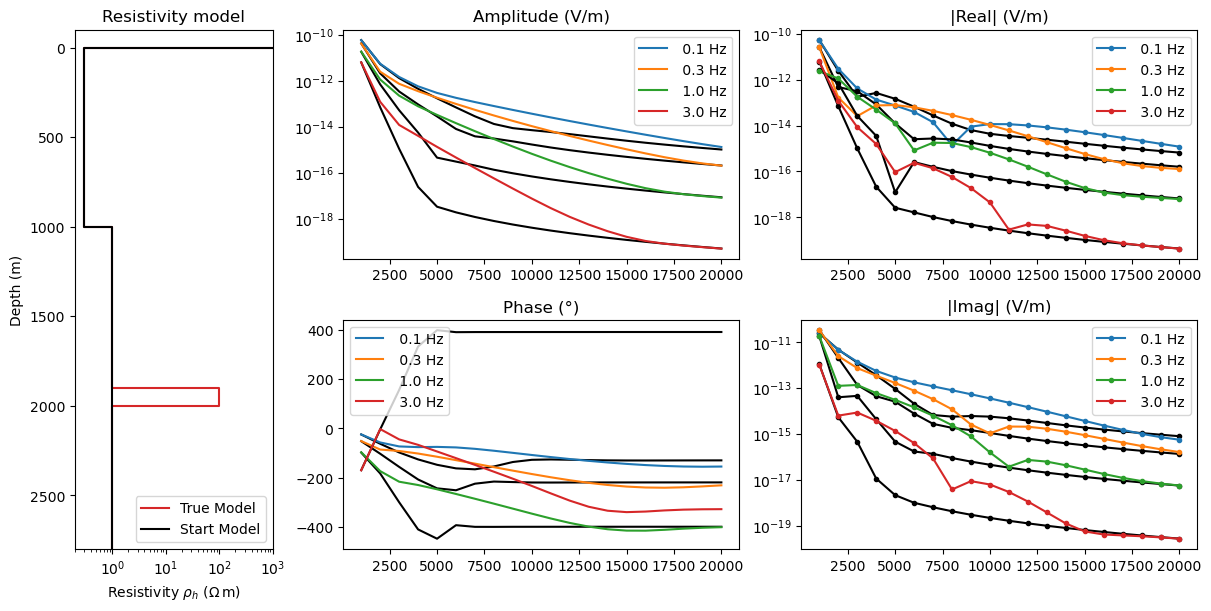

In [3]:
def plot_depth(d, r, d0=-100, dn=+100):    
    return np.repeat(r, 2), np.r_[d[0]+d0, np.repeat(d, 2), d[-1]+dn]

# Create figure
axs = plt.figure(figsize=(12, 6), constrained_layout=True).subplot_mosaic('ABBDD;ACCEE')
ax1, ax2, ax3, ax4, ax5 = axs.values()

# Plot Resistivities
ax1.set_title('Resistivity model')
ax1.plot(*plot_depth(depth, mtrue, dn=500), 'C3', label="True Model")
ax1.plot(*plot_depth(depth, m0, dn=500), 'k', label="Start Model")
ax1.set_xscale('log')
ax1.set_xlim([.2, 1000])
ax1.set_ylim([2800, -100])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Resistivity $\rho_h\ (\Omega\,\rm{m})$')
ax1.legend()

# Plot Amplitudes
ax2.set_title('Amplitude (V/m)')
for i, f in enumerate(freqs):
    ax2.plot(x, data0[i, :].amp(), 'k')
    ax2.plot(x, data[i, :].amp(), label=f"{f: 2.1f} Hz")
ax2.set_yscale('log')
ax2.legend()

# Plot Phases
ax4.set_title('Phase (°)')
for i, f in enumerate(freqs):
    ax4.plot(x, data0[i, :].pha(deg=True), 'k')
    ax4.plot(x, data[i, :].pha(deg=True), label=f"{f: 2.1f} Hz")
ax4.legend()

# Plot Real
ax3.set_title('|Real| (V/m)')
for i, f in enumerate(freqs):
    ax3.plot(x, abs(data0[i, :].real), 'k.-')
    ax3.plot(x, abs(data[i, :].real), '.-', label=f"{f: 2.1f} Hz")
ax3.set_yscale('log')
ax3.legend()

# Plot Imag
ax5.set_title('|Imag| (V/m)')
for i, f in enumerate(freqs):
    ax5.plot(x, abs(data0[i, :].imag), 'k.-')
    ax5.plot(x, abs(data[i, :].imag), '.-', label=f"{f: 2.1f} Hz")
ax5.set_yscale('log')
ax5.legend();

## Stuff that should move into `empymod.inv.pygimli`

In [4]:
class Forward(pygimli.Modelling):
    
    def __init__(self, inp, routine=None):
        """Initialize the model."""
        super().__init__()
        
        self.inp = inp
        
        self.mesh1d = pygimli.meshtools.createMesh1D(len(self.inp['depth'])-1) # free res + 1
        self.setMesh(self.mesh1d)
    
        if routine:
            self.routine = routine
        else:
            self.routine = empymod.bipole
        
    def response(self, x):
        """Forward response."""    
        # TODO: more flexible: anisotropy; thicknesses
        # => mapping function from x to inp
        res = np.r_[2e14, 0.3, x]
        em = self.routine(res=res, **self.inp)

        # Depending if time- or frequency-domain
        if np.iscomplexobj(em):
            return np.hstack((em.ravel().real, em.ravel().imag))
        else:
            return em.ravel()
    
    def createStartModel(self): # What to do with this?
        raise NotImplementedError('THINK ABOUT THIS')

## Inversion

In [5]:
inv = pygimli.Inversion(fop=Forward(inp, empymod.dipole))

# Use log resistivities, but also symlog data!
#inv.dataTrans = pygimli.trans.TransSymLog(1e-20)
#inv.transModel = pygimli.trans.TransLog(0.1) # > 1 Ohmm

model = inv.run(
    dataVals=np.hstack((data.ravel().real, data.ravel().imag)),
    relativeError=np.hstack((error.ravel(), error.ravel())),
    startModel=m0[2:],
    verbose=True
)

minv = np.r_[np.nan, np.nan, np.array(model)]
response = np.array(inv.response)
response = empymod.EMArray(np.reshape(response[:data.size] + 1j*response[data.size:], data.shape))

12/02/24 - 13:44:14 - pyGIMLi - WARNING - Found zero error values. Setting them to fallback value of 1
12/02/24 - 13:44:14 - pyGIMLi - INFO - Starting inversion.
./core/src/inversion.h:247		void GIMLI::RInversion::checkError()  Warning error contains zero values, reset to default. 


[2.84970337e-12 2.72775815e-13 7.25896656e-14 2.84615171e-14
 1.47213832e-14 9.01800973e-15 5.91026863e-15 3.96661808e-15
 2.69243624e-15 1.84374334e-15 1.27351993e-15 8.87234453e-16
 6.23218193e-16 4.41120047e-16 3.14448968e-16 2.25703114e-16
 1.63212752e-16 1.19107243e-16 8.80062421e-17 6.61715346e-17
 2.04436893e-12 1.22702581e-13 3.66831926e-14 1.75250238e-14
 9.10123706e-15 4.90546784e-15 2.71864864e-15 1.54415117e-15
 8.97454193e-16 5.33163049e-16 3.23415444e-16 2.00036619e-16
 1.25951047e-16 8.06310611e-17 5.25021833e-17 3.49006436e-17
 2.38882441e-17 1.70535955e-17 1.28507054e-17 1.02505770e-17
 9.11850585e-13 5.62022458e-14 1.12163352e-14 3.86708247e-15
 1.63878643e-15 7.17076144e-16 3.21432350e-16 1.47422737e-16
 6.92936027e-17 3.35673899e-17 1.68833991e-17 8.86491618e-18
 4.86357052e-18 2.78621997e-18 1.67703016e-18 1.08131472e-18
 7.64186902e-19 5.92432612e-19 4.90535921e-19 4.20627719e-19
 3.11993304e-13 6.06407084e-15 6.00221824e-16 2.01678654e-16
 6.71485392e-17 2.311028

## Plot result

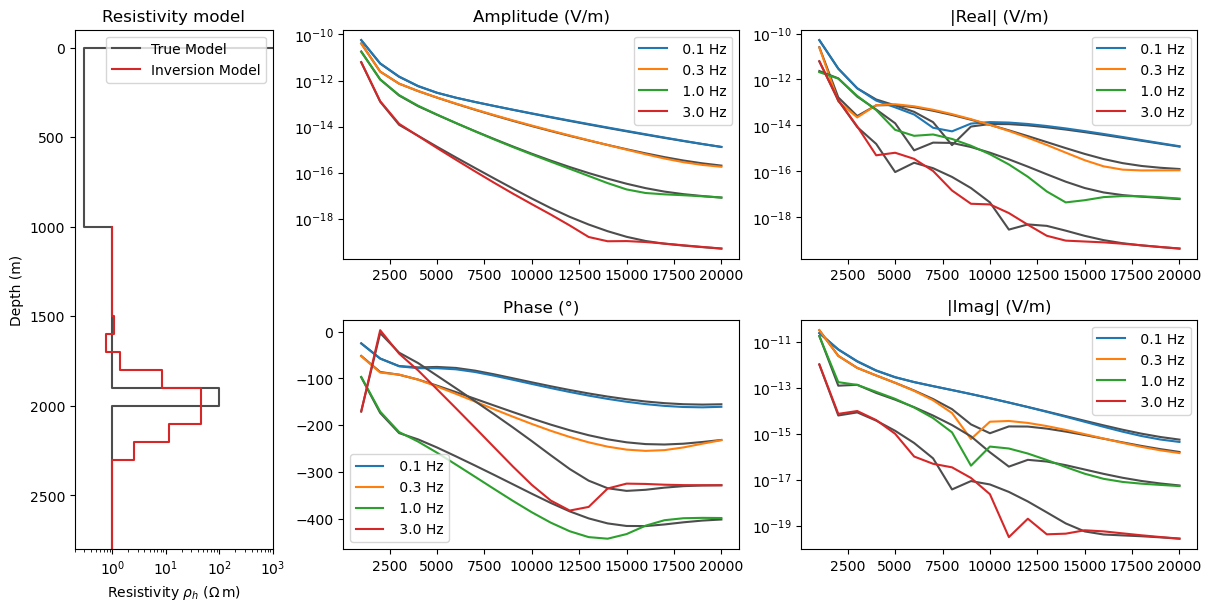

In [6]:
# Create figure
axs = plt.figure(figsize=(12, 6), constrained_layout=True).subplot_mosaic('ABBDD;ACCEE')
ax1, ax2, ax3, ax4, ax5 = axs.values()

# Plot Resistivities
ax1.set_title('Resistivity model')
#ax1.plot(*plot_depth(depth, m0, dn=500), 'k', label="Start Model")
ax1.plot(*plot_depth(depth, mtrue, dn=500), '.3', label="True Model")
ax1.plot(*plot_depth(depth, minv, dn=500), 'C3', label="Inversion Model")
ax1.set_xscale('log')
ax1.set_xlim([.2, 1000])
ax1.set_ylim([2800, -100])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Resistivity $\rho_h\ (\Omega\,\rm{m})$')
ax1.legend()

# Plot Amplitudes
ax2.set_title('Amplitude (V/m)')
for i, f in enumerate(freqs):
    #ax2.plot(x, data0[i, :].amp(), 'k')
    ax2.plot(x, data[i, :].amp(), '.3')
    ax2.plot(x, response[i, :].amp(), label=f"{f: 2.1f} Hz")
ax2.set_yscale('log')
ax2.legend()

# Plot Phases
ax4.set_title('Phase (°)')
for i, f in enumerate(freqs):
    #ax4.plot(x, data0[i, :].pha(deg=True), 'k')
    ax4.plot(x, data[i, :].pha(deg=True), '.3')
    ax4.plot(x, response[i, :].pha(deg=True), label=f"{f: 2.1f} Hz")
ax4.legend()

# Plot Real
ax3.set_title('|Real| (V/m)')
for i, f in enumerate(freqs):
    #ax3.plot(x, abs(data0[i, :].real), 'k')
    ax3.plot(x, abs(data[i, :].real), '.3')
    ax3.plot(x, abs(response[i, :].real), label=f"{f: 2.1f} Hz")
ax3.set_yscale('log')
ax3.legend()

# Plot Imag
ax5.set_title('|Imag| (V/m)')
for i, f in enumerate(freqs):
    #ax5.plot(x, abs(data0[i, :].imag), 'k')
    ax5.plot(x, abs(data[i, :].imag), '.3')
    ax5.plot(x, abs(response[i, :].imag), label=f"{f: 2.1f} Hz")
ax5.set_yscale('log')
ax5.legend();

In [7]:
empymod.Report(['pyGIMLi', 'pgcore'])

--------------------------------------------------------------------------------
  Date: Mon Feb 12 13:44:15 2024 CET

                OS : Linux
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37)
  [GCC 12.3.0]

           pyGIMLi : 1.4.6+41.g320f5fcc
            pgcore : 1.4.0
             numpy : 1.24.4
             scipy : 1.12.0
             numba : 0.58.1
           empymod : 2.2.2
           IPython : 8.20.0
        matplotlib : 3.8.2
--------------------------------------------------------------------------------